# FF-QRAM Demo

We implemented a [FF-QRAM](https://www.nature.com/articles/s41598-019-40439-3) template circuit with `pennylane`, and reproduced the example circuit in Fig. 6 in [](https://arxiv.org/abs/2305.01178).

In [1]:
import pennylane as qml
from pennylane import numpy as np
import matplotlib.pyplot as plt
qml.drawer.use_style('pennylane')

def apply_ffqram_block(addr_bits, addr_wires, data_bits, data_wires, angle, reg_wire):
    '''
    Encode a single data entry into the FF-QRAM circuit.

    Parameters:
        addr_bits (list[int]): Bit list representing the address.
        addr_wires (list[int]): Wire indices for the address qubits.
        data_bits (list[int]): Bit list representing the data.
        data_wires (list[int]): Wire indices for the data qubits.
        angle (float): Rotation angle derived from the data bit string.
        reg_wire (int): Wire index for the register qubit.
    '''
    # 1. flip
    for i, bit in enumerate(addr_bits):
        if bit == 0:
            qml.PauliX(wires=addr_wires[i])
    for i, bit in enumerate(data_bits):
        if bit == 0:
            qml.PauliX(wires=data_wires[i])

    # 2. register
    qml.ctrl(qml.RY, control=addr_wires + data_wires)(angle, wires=reg_wire)

    # 3. flop (unflip)
    for i, bit in enumerate(addr_bits):
        if bit == 0:
            qml.PauliX(wires=addr_wires[i])
    for i, bit in enumerate(data_bits):
        if bit == 0:
            qml.PauliX(wires=data_wires[i])

def ffqram_circuit(entries):
    '''
    Encode an array of address-data pairs into the FF-QRAM circuit.

    Parameters:
        entries (np.ndarray): 2D array where each row contains an (address, data) pair as integers.
    '''
    # decide number of address and data qubits
    max_addr = np.max(entries[:, 0])
    max_data = np.max(entries[:, 1])
    n_addr = int(np.ceil(np.log2(max_addr + 1)))
    n_data = int(np.ceil(np.log2(max_data + 1)))

    # default wire order: addr, data, reg
    addr_wires = list(range(n_addr))
    data_wires = list(range(n_addr, n_addr + n_data))
    reg_wire = data_wires[-1] + 1

    # compute rotation angles for each entry
    data_values = entries[:, 1].astype(float)
    norm = np.linalg.norm(data_values)
    normalized = data_values / norm
    angles = 2 * np.arcsin(normalized)

    # initialize to an equal superposition
    for w in addr_wires + data_wires:
        qml.Hadamard(wires=w)
        
    # encoding
    for i, (addr_int, data_int) in enumerate(entries):
        qml.Barrier(only_visual=True)
        # Convert integer to bit lists (e.g. 3 -> [1, 1])
        addr_bits = [int(b) for b in format(addr_int, f'0{n_addr}b')]
        data_bits = [int(b) for b in format(data_int, f'0{n_data}b')]
        angle = angles[i]

        apply_ffqram_block(addr_bits, addr_wires, data_bits, data_wires, angle, reg_wire)

## Example

We encoded the data entry {2, 3, 1, 1}, so $M=4$, $m=2$.

The rotation angles are therefore:

$$
2\arcsin\frac{\{2, 3, 1, 1\}}{\sqrt{2^2+3^2+1^2+1^2}} = \{1.09, 1.74, 0.52, 0.52\}.
$$

Expected probability conditioned on $|1\rangle_R$:

|address|data|state|prob|
|---|---|---|---|
|0|2|$\|0010\rangle$|$4/15=0.267$|
|1|3|$\|0111\rangle$|$9/16=0.6$|
|2|1|$\|1001\rangle$|$1/15=0.067$|
|2|1|$\|1101\rangle$|$1/15=0.067$|

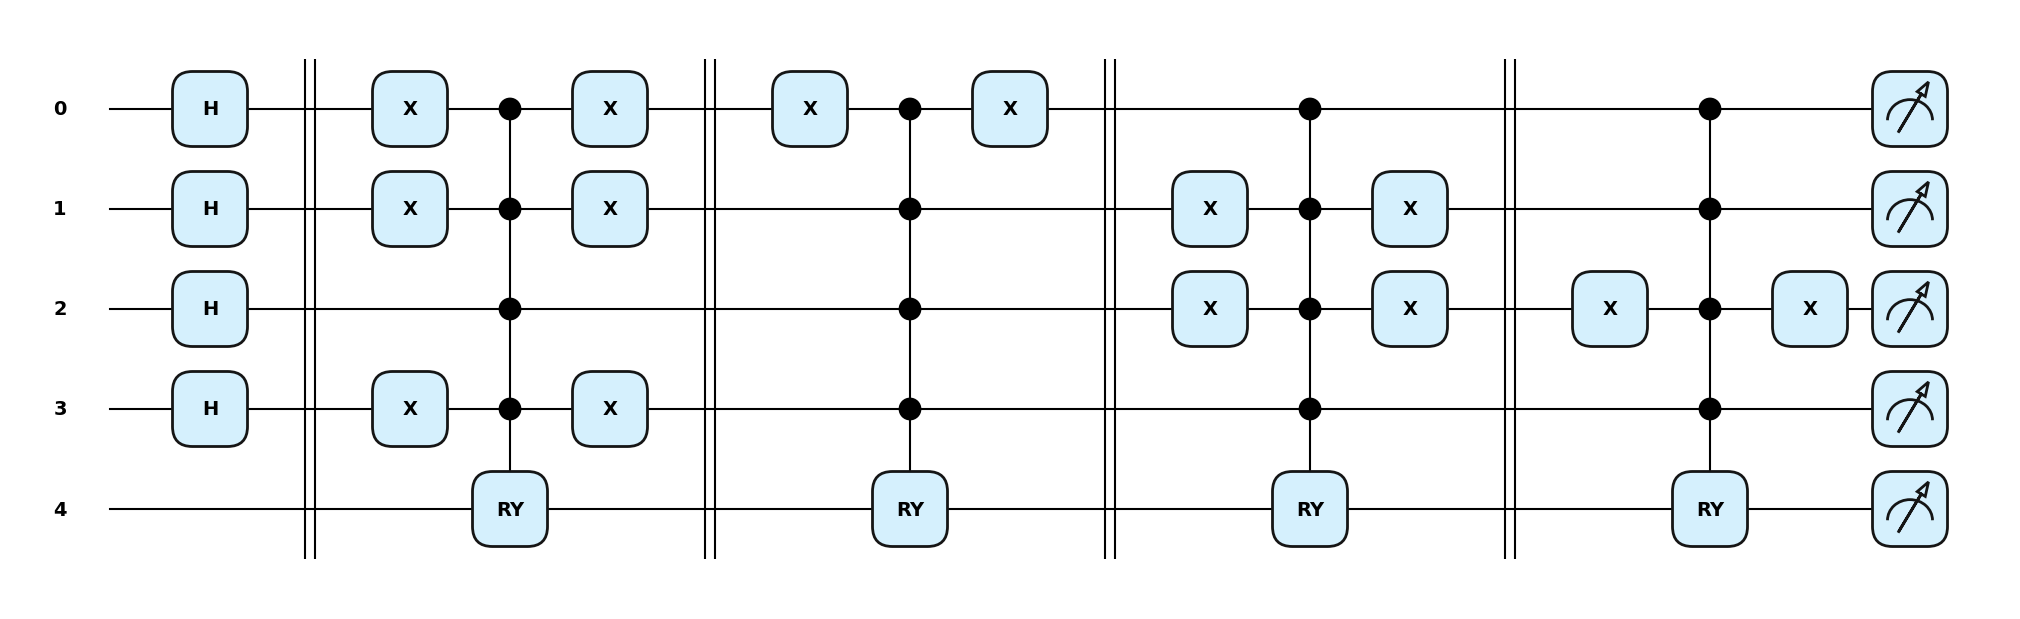

In [2]:
entries = np.array([[0, 2], [1, 3], [2, 1], [3, 1]])

dev = qml.device('default.qubit', wires=5)
shots = 5000
@qml.set_shots(shots)
@qml.qnode(dev, interface=None)
def circuit():
    ffqram_circuit(entries)
    return qml.counts()

qml.draw_mpl(circuit)()
plt.show()

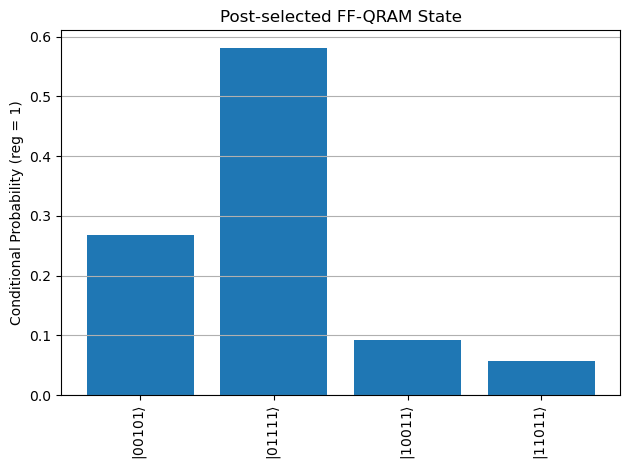

Measured P(reg=1) = 0.0626
Expected P(reg=1) = 0.0625


In [3]:
results = circuit()

# Post-select on register qubit = 1 (i.e., LSB == '1')
filtered_states = []
filtered_counts = []

for state, count in results.items():
    if state[-1] == '1':  # Post-select register qubit = 1
        filtered_states.append(rf"$|{state}\rangle$")
        filtered_counts.append(count)

# Normalize to conditional probabilities
filtered_counts = np.array(filtered_counts)
p_reg1 = filtered_counts.sum() / shots
conditioned_probs = filtered_counts / shots / p_reg1

# Plot conditional probabilities
plt.figure()
plt.bar(filtered_states, conditioned_probs)
plt.ylabel("Conditional Probability (reg = 1)")
plt.title(f"Post-selected FF-QRAM State")
plt.xticks(rotation=90)
plt.grid(axis='y')
plt.tight_layout()
plt.show()

print(f'Measured P(reg=1) = {p_reg1:.4f}')
print('Expected P(reg=1) = 0.0625')